In [ ]:
!pip install transformers accelerate bitsandbytes torch

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [ ]:
class HealthState(TypedDict):
    patient_input: str
    vitals_validation: str
    risk_classification: str
    clinical_advice: str

In [ ]:
model_id = "microsoft/Phi-3-mini-4k-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

Loading weights:   0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:
def phi_chat(system_prompt: str, user_prompt: str, temperature=0.0, max_tokens=200):

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        temperature=temperature,
        do_sample=False,
        max_new_tokens=max_tokens
    )

    generated_tokens = outputs[0][inputs["input_ids"].shape[1]:]

    return tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

In [ ]:
import re

def vitals_sanity_agent(state: HealthState) -> HealthState:
    text = state["patient_input"]

    try:
        hr_match = re.search(r"Heart Rate:\s*(\d+)", text)
        bp_match = re.search(r"Systolic BP:\s*(\d+)", text)
        spo2_match = re.search(r"Oxygen Saturation:\s*(\d+)", text)
        temp_match = re.search(r"Temperature:\s*([\d.]+)", text)

        if not hr_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Heart Rate."
            }

        if not bp_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Systolic BP."
            }

        if not spo2_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Oxygen Saturation."
            }

        if not temp_match:
            return {
                "patient_input": text,
                "vitals_validation": "INVALID: Missing Temperature."
            }

        hr = int(hr_match.group(1))
        bp = int(bp_match.group(1))
        spo2 = int(spo2_match.group(1))
        temp = float(temp_match.group(1))

    except Exception:
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Unable to parse vital values."
        }

    # Strict numeric boundaries
    if not (30 <= hr <= 220):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Heart Rate is outside allowed range (30–220 bpm)."
        }

    if not (50 <= bp <= 250):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Systolic BP is outside allowed range (50–250 mmHg)."
        }

    if not (50 <= spo2 <= 100):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Oxygen Saturation is outside allowed range (50–100%)."
        }

    if not (30 <= temp <= 45):
        return {
            "patient_input": text,
            "vitals_validation": "INVALID: Temperature is outside allowed range (30–45 °C)."
        }

    # If everything passes
    return {
        "patient_input": text,
        "vitals_validation": "VALID"
    }

In [ ]:
def risk_classification_agent(state: HealthState) -> HealthState:

    # Safety Gate
    if "INVALID" in state["vitals_validation"]:
        return {
            "patient_input": state["patient_input"],
            "vitals_validation": state["vitals_validation"],
            "risk_classification": "Cannot classify due to invalid vitals",
            "clinical_advice": ""
        }

    system_prompt = """
You are a medical risk classification agent.

Your task:
- Classify patient condition into exactly ONE of the following labels:

Stable
Moderate Risk
Critical

Base your decision ONLY on:
- Heart Rate
- Systolic Blood Pressure
- Oxygen Saturation
- Temperature

Do NOT validate values.
Do NOT give treatment advice.
Do NOT invent new labels.

Output EXACTLY one of:
Stable
Moderate Risk
Critical

---

### Few-Shot Examples

Example 1:
Heart Rate: 72 bpm
Systolic BP: 118 mmHg
Oxygen Saturation: 99 %
Temperature: 36.7 °C
Risk: Stable

Example 2:
Heart Rate: 80 bpm
Systolic BP: 125 mmHg
Oxygen Saturation: 97 %
Temperature: 37.0 °C
Risk: Stable

Example 3:
Heart Rate: 65 bpm
Systolic BP: 110 mmHg
Oxygen Saturation: 98 %
Temperature: 36.5 °C
Risk: Stable

Example 4:
Heart Rate: 88 bpm
Systolic BP: 130 mmHg
Oxygen Saturation: 96 %
Temperature: 37.2 °C
Risk: Stable

Example 5:
Heart Rate: 75 bpm
Systolic BP: 115 mmHg
Oxygen Saturation: 97 %
Temperature: 36.9 °C
Risk: Stable

Example 6:
Heart Rate: 110 bpm
Systolic BP: 100 mmHg
Oxygen Saturation: 93 %
Temperature: 38.2 °C
Risk: Moderate Risk

Example 7:
Heart Rate: 120 bpm
Systolic BP: 95 mmHg
Oxygen Saturation: 92 %
Temperature: 38.5 °C
Risk: Moderate Risk

Example 8:
Heart Rate: 105 bpm
Systolic BP: 105 mmHg
Oxygen Saturation: 94 %
Temperature: 37.8 °C
Risk: Moderate Risk

Example 9:
Heart Rate: 98 bpm
Systolic BP: 90 mmHg
Oxygen Saturation: 91 %
Temperature: 38.0 °C
Risk: Moderate Risk

Example 10:
Heart Rate: 115 bpm
Systolic BP: 92 mmHg
Oxygen Saturation: 93 %
Temperature: 39.0 °C
Risk: Moderate Risk

Example 11:
Heart Rate: 150 bpm
Systolic BP: 75 mmHg
Oxygen Saturation: 85 %
Temperature: 39.5 °C
Risk: Critical

Example 12:
Heart Rate: 165 bpm
Systolic BP: 70 mmHg
Oxygen Saturation: 82 %
Temperature: 40.0 °C
Risk: Critical

Example 13:
Heart Rate: 45 bpm
Systolic BP: 80 mmHg
Oxygen Saturation: 84 %
Temperature: 35.0 °C
Risk: Critical

Example 14:
Heart Rate: 140 bpm
Systolic BP: 65 mmHg
Oxygen Saturation: 88 %
Temperature: 40.5 °C
Risk: Critical

---

### Patient Vitals:
"""


    response = phi_chat(
        system_prompt,
        state["patient_input"],
        temperature=0.0,
        max_tokens=10
    )

    clean_output = response.strip()

    if "Critical" in clean_output:
        clean_output = "Critical"
    elif "Moderate" in clean_output:
        clean_output = "Moderate Risk"
    elif "Stable" in clean_output:
        clean_output = "Stable"
    else:
        clean_output = "Stable"

    return {
        "patient_input": state["patient_input"],
        "vitals_validation": state["vitals_validation"],
        "risk_classification": clean_output,
        "clinical_advice": ""
    }

In [ ]:
def clinical_advice_agent(state: HealthState) -> HealthState:

    if "INVALID" in state["vitals_validation"]:
        return {
            "patient_input": state["patient_input"],
            "vitals_validation": state["vitals_validation"],
            "risk_classification": state["risk_classification"],
            "clinical_advice": "Vitals are invalid. Please recheck measurements before clinical interpretation."
        }

    system_prompt = """
You are a medical advisory agent.

Your task:
- Provide short, clear clinical guidance based ONLY on the risk classification.
- Use simple, non-technical language.
- Keep response concise (2-3 sentences maximum).

Rules:
- If Risk is Stable → reassure and suggest routine monitoring.
- If Risk is Moderate Risk → suggest closer observation and possible evaluation.
- If Risk is Critical → recommend immediate medical attention or escalation.

Do NOT:
- Reclassify risk
- Validate vitals
- Mention internal reasoning
- Provide medication names
- Provide dosage instructions

Keep advice general and safe.
"""

    response = phi_chat(
        system_prompt,
        f"""
Patient Vitals:
{state['patient_input']}

Risk Classification:
{state['risk_classification']}
""",
        temperature=0.2,
        max_tokens=100
    )

    return {
        "patient_input": state["patient_input"],
        "vitals_validation": state["vitals_validation"],
        "risk_classification": state["risk_classification"],
        "clinical_advice": response.strip()
    }

In [ ]:
workflow = StateGraph(HealthState)

workflow.add_node("vitals_sanity_check", vitals_sanity_agent)
workflow.add_node("risk_classification", risk_classification_agent)
workflow.add_node("clinical_advice", clinical_advice_agent)

workflow.add_edge(START, "vitals_sanity_check")
workflow.add_edge("vitals_sanity_check", "risk_classification")
workflow.add_edge("risk_classification", "clinical_advice")
workflow.add_edge("clinical_advice", END)

app = workflow.compile()

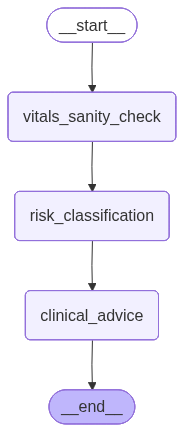

In [ ]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:
def format_final_output(result: dict):
    print("=" * 60)
    print("PATIENT RISK ASSESSMENT REPORT")
    print("=" * 60)

    print("\nVITALS SANITY CHECK")
    print(result["vitals_validation"])

    print("\nRISK CLASSIFICATION")
    print(result["risk_classification"])

    print("\nCLINICAL ADVICE")
    print(result["clinical_advice"])

    print("\nFINAL VERDICT")

    if "INVALID" in result["vitals_validation"]:
        print("Assessment cannot proceed due to invalid vital measurements.")

    elif result["risk_classification"] == "Critical":
        print("Patient condition is CRITICAL. Immediate medical attention required.")

    elif result["risk_classification"] == "Moderate Risk":
        print("Patient condition is concerning. Close monitoring is advised.")

    elif result["risk_classification"] == "Stable":
        print("Patient condition appears stable. Continue routine observation.")

    else:
        print("Unable to determine final verdict.")

    print("=" * 60)

In [ ]:
patient_input = """
Heart Rate: 72 bpm
Systolic BP: 118 mmHg
Oxygen Saturation: 99 %
Temperature: 36.7 °C
"""

result = app.invoke({"patient_input": patient_input})
format_final_output(result)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
VALID

RISK CLASSIFICATION
Stable

CLINICAL ADVICE
Based on your stable risk classification, you can continue with your regular activities. However, it's important to keep an eye on your health and report any significant changes to your healthcare provider.

FINAL VERDICT
Patient condition appears stable. Continue routine observation.


In [ ]:
patient_input = """
Heart Rate: 200 bpm
Systolic BP: 70 mmHg
Oxygen Saturation: 85 %
Temperature: 40.0 °C
"""

result = app.invoke({"patient_input": patient_input})
format_final_output(result)

PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
VALID

RISK CLASSIFICATION
Critical

CLINICAL ADVICE
Given the critical risk classification, it's essential to seek immediate medical attention. The patient'emenity is showing signs of distress with a high heart rate, low blood pressure, low oxygen saturation, and a high fever. This requires urgent evaluation by healthcare professionals to prevent serious complications.

FINAL VERDICT
Patient condition is CRITICAL. Immediate medical attention required.


In [ ]:
patient_input = """
Heart Rate: 117 bpm
Systolic BP: 95 mmHg
Oxygen Saturation: 92 %
Temperature: 38.8 °C
"""

result = app.invoke({"patient_input": patient_input})
format_final_output(result)

PATIENT RISK ASSESSMENT REPORT

VITALS SANITY CHECK
VALID

RISK CLASSIFICATION
Moderate Risk

CLINICAL ADVICE
Given the moderate risk classification, it's important to closely monitor the patient's condition. Please ensure they are observed regularly, and consider further evaluation to determine the cause of the elevated temperature and heart rate. Keep an eye on their oxygen saturation and blood pressure as well.

FINAL VERDICT
Patient condition is concerning. Close monitoring is advised.
